# Invalid OSA for Nestle-Cereals Tesco, Morrisons, Asda

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import datetime as dtm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

import warnings
warnings.filterwarnings('ignore')
style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 8)

### Load data

In [3]:
def load_files(retailer):
    df = pd.read_csv(f'/anfvol1/Tara-Notebooks/data/nestle_cereals_{retailer}_new_alert_2020.01.27_drt_uk.csv',
                parse_dates=['SALES_DT'])
    df = df.rename(str.lower, axis='columns')
    df.loc[:, 'drfe_pos_item_qty'] = df['drfe_pos_item_qty'].clip(0, 100000)
    df = df.rename({'drfe_pos_item_qty':'expected_pos'}, axis='columns')
    return df

### Generate OSA alerts

In [4]:
def lsv(df, only_positive_error='True'):
    df.loc[:, 'error'] = df['expected_pos'] - df['pos_item_qty']
    
    if only_positive_error=='True':
        df.loc[:, 'error'][df['error']<0] = 0
        
    df = df.sort_values(['retailer_item_id', 'organization_unit_num', 'sales_dt'])
    avg_error = df.groupby(['retailer_item_id', 'organization_unit_num'], as_index=False)['error'].rolling(2).mean().shift(1)
    avg_price = df.groupby(['retailer_item_id', 'organization_unit_num'], as_index=False)['price'].rolling(2).mean().shift(1)
    lsv_df = avg_error * avg_price
    
    df = df.join(pd.DataFrame(data=lsv_df.values, columns=['LSV'], index=[x[1] for x in lsv_df.index]))
    df = df.join(pd.DataFrame(data=avg_error.values, columns=['Alert'], index=[x[1] for x in avg_error.index]))
    
    df.loc[:, 'LSV'][df['LSV']<=0]=np.nan
    df.loc[:, 'Alert'][df['Alert']<=0]=np.nan
    return df

### Invalid osa

In [5]:
def add_daily_group(df, col_name='expected_pos', percentile_list=[0.8, 0.6], minimum_pos=3):
    """
    Assigns each store/day to one of high-, middle-, slow-selling group
    
    param df: input dataframe for one item
    param string col_name: choose beteween 'pos_item_qty' or 'expected_pos'
    param list percentile_list: [high percentile, low percentile]
    param int minimum_pos: minimum pos to define a slow selling item
    """
    
    percentile_high, percentile_low = percentile_list
    top_threshold_qty = df[col_name].quantile(percentile_high)
    middle_threshold_qty = df[col_name].quantile(percentile_low)
    
    df['group'] = df.shape[0] * np.nan
    if middle_threshold_qty <3:
        df.loc[:, 'group'] = 'slow'
    else:
        df.loc[:, 'group'][(df[col_name]>middle_threshold_qty) & (df[col_name]<=top_threshold_qty)] = 'middle'
        df.loc[:, 'group'][df[col_name]>top_threshold_qty] = 'top'
        df.loc[:, 'group'][df[col_name]<=middle_threshold_qty] = 'slow'
    
    return df

def select_percentile_comb(df, percentile=0.8):
    """
    Calculates how often a item/store aprears in each group. In the list of all appeared days,
    calculated x-percentile is the threshold to select stores.
    param datafram df: Input dataframe with a column group
    param float percentile: percentile to calculate the infimum number of days
    return dataframe: dataframe which contains valid stores for each retailer_item_id and group
    """
    grouped_days = df.groupby(['retailer_item_id', 'organization_unit_num', 'group'], 
                                as_index=False)['sales_dt'].count()\
                        .rename({'sales_dt': '# days in the group'}, axis='columns')
    grouped_stores = grouped_days.groupby(['retailer_item_id', 'group'], 
                                          as_index=False)['# days in the group'].quantile(percentile)\
                        .rename({'# days in the group': 'membership_threshold'}, axis='columns')
    
    grouped_days = grouped_days.merge(grouped_stores)
    
    grouped_days = grouped_days[grouped_days['# days in the group']>=grouped_days['membership_threshold']]
    
    return grouped_days

In [6]:
def invalid_osa(df, valid_osa_ratio):
    print(df.columns)
    total_store_num = df.groupby(['retailer_item_id'], as_index=False)['organization_unit_num'].count().rename({'organization_unit_num': 'total_store_num'}, axis='columns')

    df = df[df['LSV']>0][['retailer_item_id', 'organization_unit_num', 'sales_dt']]
    
    days_store_num = df.groupby(['retailer_item_id', 'sales_dt'], as_index=False)['organization_unit_num'].count().rename({'organization_unit_num': 'count_stores'}, axis='columns')
    days_store_num = days_store_num.merge(total_store_num)
    days_store_num.loc[:, 'ratio_stores'] = days_store_num['count_stores']/days_store_num['total_store_num']
    
    return days_store_num[days_store_num['ratio_stores']>=valid_osa_ratio]

In [7]:
def build_alert_table(df, col_name, membership_multiplier):
    df_with_q3 = df.groupby(['retailer_item_id', 'group', 'sales_dt'], as_index=False)[col_name].quantile(0.75).rename({col_name: 'Q3'}, axis='columns')
    df_with_q1 = df.groupby(['retailer_item_id', 'group', 'sales_dt'], as_index=False)[col_name].quantile(0.25).rename({col_name: 'Q1'}, axis='columns')
    df_with_q1_q3 = df_with_q3.merge(df_with_q1)
    df_with_q1_q3.loc[:, 'outlier threshold'] = df_with_q1_q3['Q1'] - membership_multiplier * (df_with_q1_q3['Q3'] - df_with_q1_q3['Q1'])

    df = df.merge(df_with_q1_q3)
    
    df_low_sales_alert= df[(df[col_name]<= df['outlier threshold'])]
    df_low_sales_alert.loc[:, 'LSV Low Sales'] = (df_low_sales_alert['Q1'] - df_low_sales_alert[col_name]) * df_low_sales_alert['price']
    return df_low_sales_alert

### Analysis

In [8]:
def analysis(df):
    selected_cols = ['sales_dt', 'organization_unit_num', 'retailer_item_id', 'pos_item_qty', 'pos_amt', 'expected_pos']

    print(df['sales_dt'].max())

    start_date = '2019-09-01'
    end_date = '2020-01-20'
    minimum_day_ratio = 0.4

    df_inp = df[selected_cols][(df['sales_dt']>=start_date) & (df['sales_dt']<=end_date)]

    df_grouped = df_inp.groupby(['retailer_item_id']).apply(add_daily_group)

    print(df_inp.shape)
    # drop all days in group 'slow'
    df_grouped = df_grouped[df_grouped['group']!='slow']

    membership_threshold_df = select_percentile_comb(df_grouped, 0.8)

    # Decide to accept threshold
    minimum_days = (dtm.datetime.strptime(end_date, '%Y-%m-%d') - dtm.datetime.strptime(start_date, '%Y-%m-%d')).days
    membership_threshold_df = membership_threshold_df[membership_threshold_df['membership_threshold']>=minimum_day_ratio*minimum_days]

    df_out = df_inp.merge(membership_threshold_df)
    print(df_out.shape)

    assigned_grouped = df_out.groupby(['organization_unit_num', 'retailer_item_id', 'group'], as_index=False)['organization_unit_num', 'retailer_item_id', 'group'].apply(lambda x: x.drop_duplicates())

    df_lastDay = df_tesco[df_tesco['sales_dt']=='2020-01-26']
    df_lastDay.loc[:, 'price'] = df_lastDay['pos_amt']/df_lastDay['pos_item_qty']
    df_lastDay = df_lastDay.merge(assigned_grouped, how='inner')

    membership_multiplier = 1
    df_low_sales_alert = build_alert_table(df_lastDay, col_name='expected_pos', membership_multiplier=membership_multiplier)
    
    return assigned_grouped, df_low_sales_alert

In [9]:
df_tesco = load_files('tesco')
store_item_groups, df_low_sales_alert_tesco = analysis(df_tesco)
df_low_sales_alert_tesco.head()

2020-01-27 00:00:00
(3666593, 6)
(252840, 9)


,organization_unit_num,retailer_item_id,retailer_item_desc,retailer,client,country_code,sales_dt,pos_item_qty,pos_amt,on_hand_inventory_qty,...,drfe_error,drfe_load_ts,sku,total,price,group,Q3,Q1,outlier threshold,LSV Low Sales
3,2736,85116425,TESCO BRAN FLAKES 750G,TESCO,NESTLECEREALS,UK,2020-01-26,10.0,10.50,23.0,...,-3.95,2020-01-24T12:27:03.857Z,BRAN FLAKES 750G,233744.0,1.05,middle,12.36,9.34,6.32,3.4545
10,3050,85116425,TESCO BRAN FLAKES 750G,TESCO,NESTLECEREALS,UK,2020-01-26,7.0,7.35,39.0,...,-0.92,2020-01-24T12:27:03.857Z,BRAN FLAKES 750G,233744.0,1.05,middle,12.36,9.34,6.32,3.4230
32,3164,85116425,TESCO BRAN FLAKES 750G,TESCO,NESTLECEREALS,UK,2020-01-26,7.0,7.35,37.0,...,-1.28,2020-01-24T12:27:03.857Z,BRAN FLAKES 750G,233744.0,1.05,middle,12.36,9.34,6.32,3.8010
57,3310,85116425,TESCO BRAN FLAKES 750G,TESCO,NESTLECEREALS,UK,2020-01-26,9.0,9.45,39.0,...,-3.26,2020-01-24T12:27:03.857Z,BRAN FLAKES 750G,233744.0,1.05,middle,12.36,9.34,6.32,3.7800
62,2167,85116425,TESCO BRAN FLAKES 750G,TESCO,NESTLECEREALS,UK,2020-01-26,10.0,10.50,20.0,...,-5.08,2020-01-24T12:27:03.857Z,BRAN FLAKES 750G,233744.0,1.05,middle,12.36,9.34,6.32,4.6410


In [10]:
# assign groups to stores
df_tesco = df_tesco.merge(store_item_groups)

# Find the selected items
item_list = df_low_sales_alert_tesco['retailer_item_id'].unique().tolist()
df_tesco_alerts = df_tesco[df_tesco['retailer_item_id'].isin(item_list)]

# Find history for store/items with and alert
store_item_list = df_low_sales_alert_tesco[['retailer_item_id', 'organization_unit_num']].drop_duplicates()
df_tesco_alert_history = df_tesco.merge(store_item_list)
df_tesco_alert_history.to_csv('/anfvol1/Tara-Notebooks/data/nestle_cereals_tescp_new_alert_2020.01.27_drt_uk_les_alerts.csv', index=False)

In [11]:
df_tesco_alert_history.head()

,organization_unit_num,retailer_item_id,retailer_item_desc,retailer,client,country_code,sales_dt,pos_item_qty,pos_amt,on_hand_inventory_qty,expected_pos,drfe_error,drfe_load_ts,sku,total,group
0,3060,50060324,TESCO CORN FLAKES CEREAL 500G,TESCO,NESTLECEREALS,UK,2019-09-17,19.0,11.00,41.0,15.91,-3.09,2019-10-25T03:00:05.208Z,CORNFLAKES 500G,100056.0,top
1,3060,50060324,TESCO CORN FLAKES CEREAL 500G,TESCO,NESTLECEREALS,UK,2019-10-30,11.0,6.60,17.0,10.46,-0.54,2020-01-02T22:03:31.801Z,CORNFLAKES 500G,100056.0,top
2,3060,50060324,TESCO CORN FLAKES CEREAL 500G,TESCO,NESTLECEREALS,UK,2019-11-28,20.0,12.00,85.0,12.91,-7.09,2020-01-02T22:03:31.801Z,CORNFLAKES 500G,100056.0,top
3,3060,50060324,TESCO CORN FLAKES CEREAL 500G,TESCO,NESTLECEREALS,UK,2019-12-05,18.0,10.35,58.0,17.12,-0.88,2020-01-02T22:03:31.801Z,CORNFLAKES 500G,100056.0,top
4,3060,50060324,TESCO CORN FLAKES CEREAL 500G,TESCO,NESTLECEREALS,UK,2019-09-20,22.0,13.00,37.0,25.94,3.94,2019-10-25T03:00:05.208Z,CORNFLAKES 500G,100056.0,top


In [12]:
df_low_sales_alert_tesco.groupby(['retailer_item_id'])['organization_unit_num'].count()

retailer_item_id
50060324     1
50385078     8
50494185     1
61708303     3
77300979    10
77546204     7
85116425    10
Name: organization_unit_num, dtype: int64

In [20]:
df_tesco_alerts.head()

,organization_unit_num,retailer_item_id,retailer_item_desc,retailer,client,country_code,sales_dt,pos_item_qty,pos_amt,on_hand_inventory_qty,expected_pos,drfe_error,drfe_load_ts,sku,total,group
0,5329,77300979,TESCO CHOCO SNAPS CEREAL 350G,TESCO,NESTLECEREALS,UK,2019-12-22,3.0,3.0,55.0,10.81,7.81,2020-01-02T22:03:31.801Z,TESCO CHOCO SNAPS 350G,233224.0,middle
1,5329,77300979,TESCO CHOCO SNAPS CEREAL 350G,TESCO,NESTLECEREALS,UK,2019-09-23,9.0,9.0,48.0,15.15,6.15,2020-01-02T22:03:31.801Z,TESCO CHOCO SNAPS 350G,233224.0,middle
2,5329,77300979,TESCO CHOCO SNAPS CEREAL 350G,TESCO,NESTLECEREALS,UK,2019-09-05,14.0,14.0,42.0,10.20,-3.80,2019-10-25T03:00:05.208Z,TESCO CHOCO SNAPS 350G,233224.0,middle
3,5329,77300979,TESCO CHOCO SNAPS CEREAL 350G,TESCO,NESTLECEREALS,UK,2019-11-25,9.0,9.0,65.0,10.47,1.47,2020-01-02T22:03:31.801Z,TESCO CHOCO SNAPS 350G,233224.0,middle
4,5329,77300979,TESCO CHOCO SNAPS CEREAL 350G,TESCO,NESTLECEREALS,UK,2019-10-06,17.0,17.0,42.0,8.65,-8.35,2020-01-02T22:03:31.801Z,TESCO CHOCO SNAPS 350G,233224.0,middle


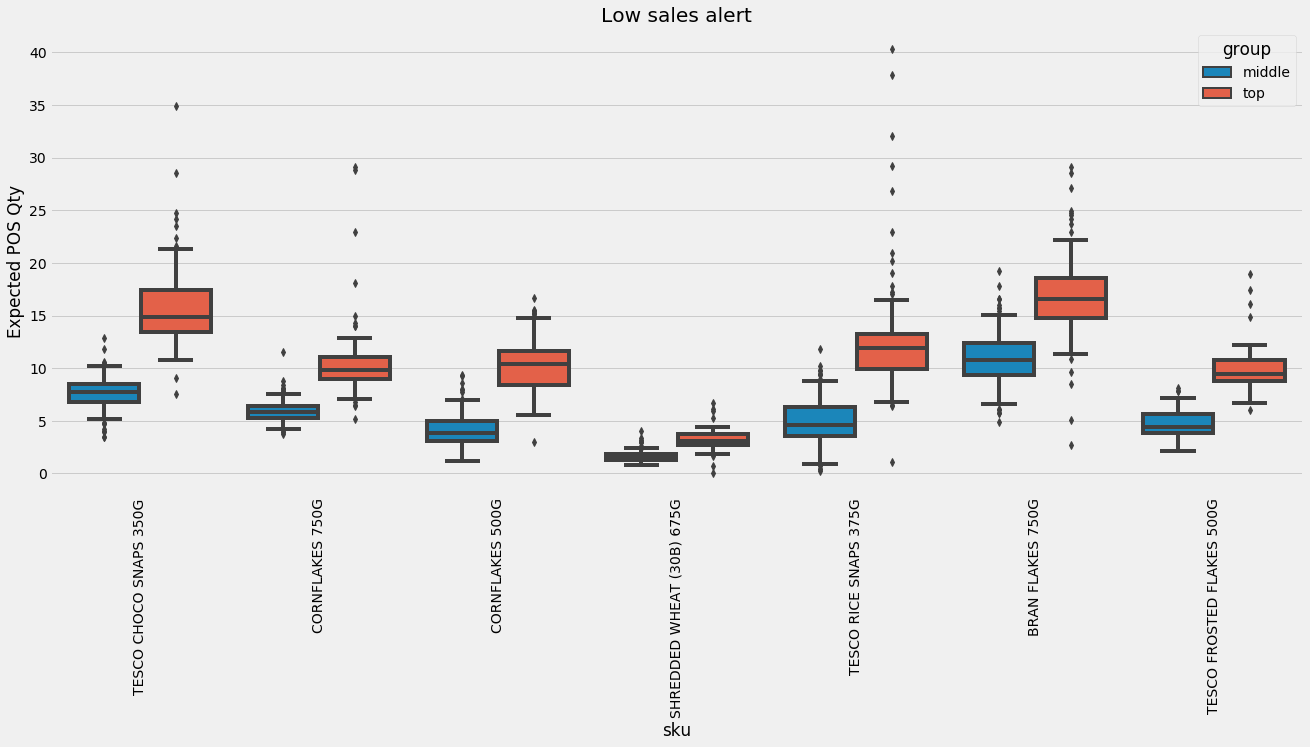

In [22]:
d = df_tesco_alerts[df_tesco_alerts['sales_dt'] == '2020-01-26']

fig, ax = plt.subplots()

sns.boxplot(x='sku', y='expected_pos', hue='group', whis=1, data=d, ax=ax)
plt.xticks(rotation='vertical')
plt.ylabel('Expected POS Qty')
plt.title(f'Low sales alert')
plt.show()

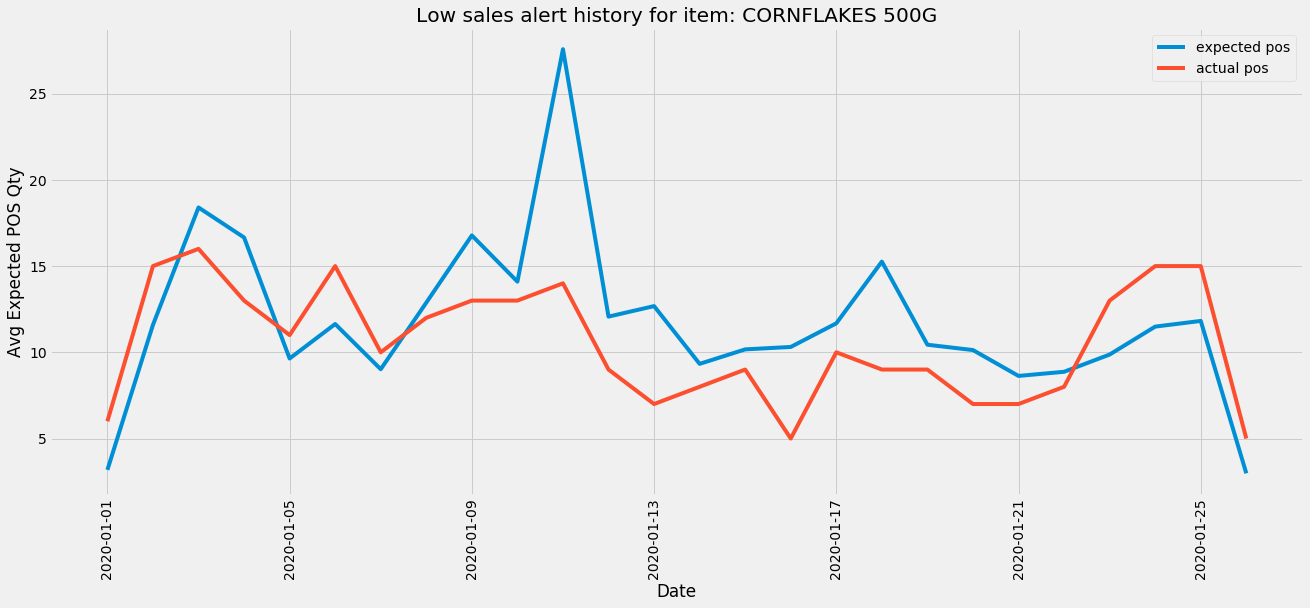

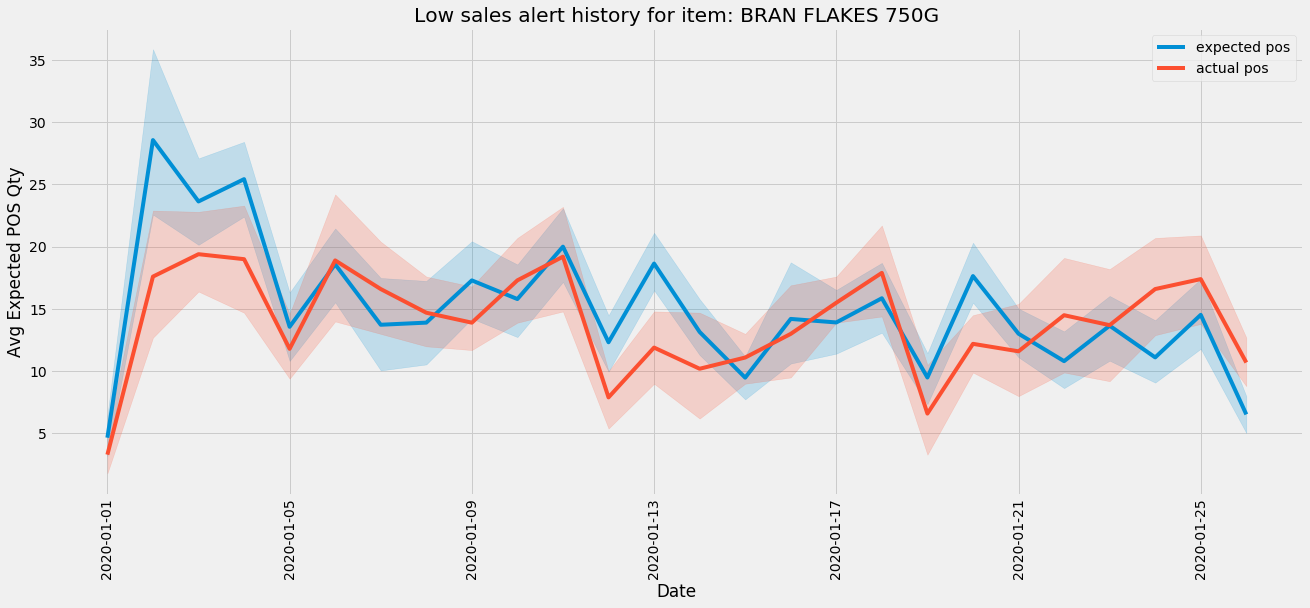

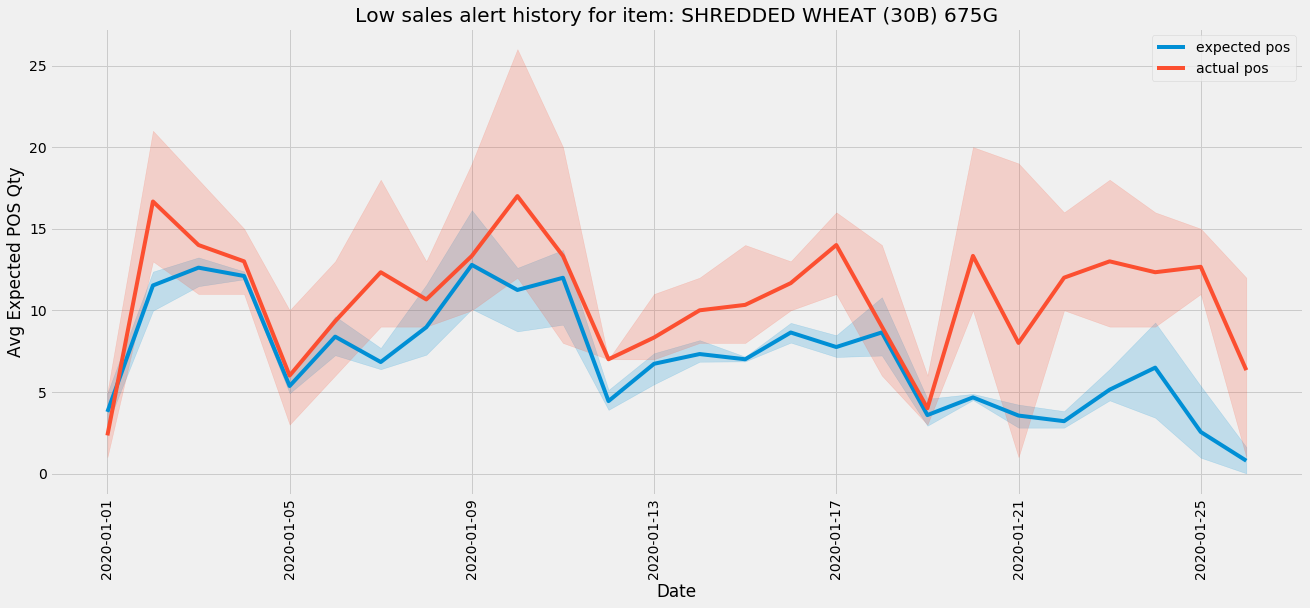

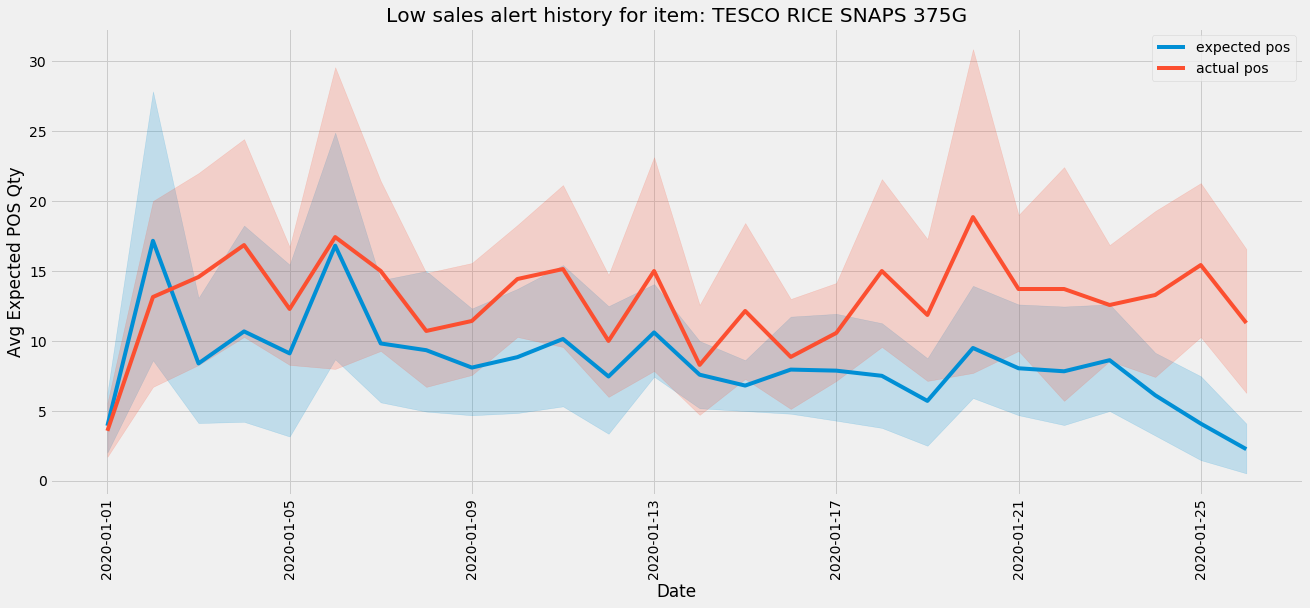

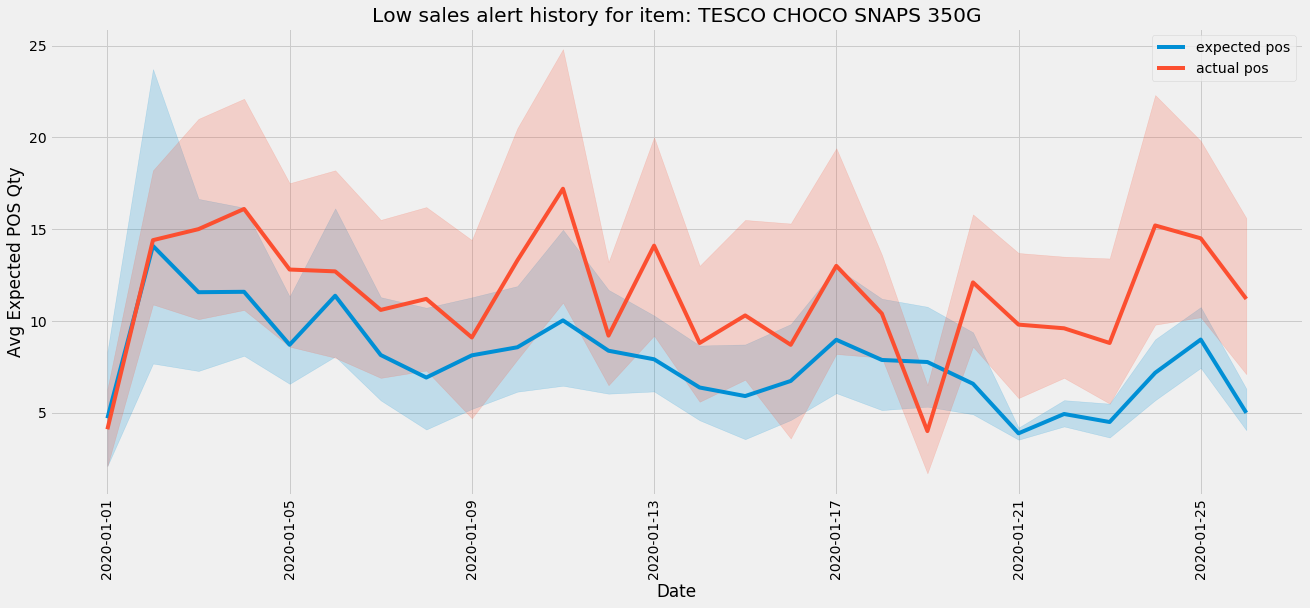

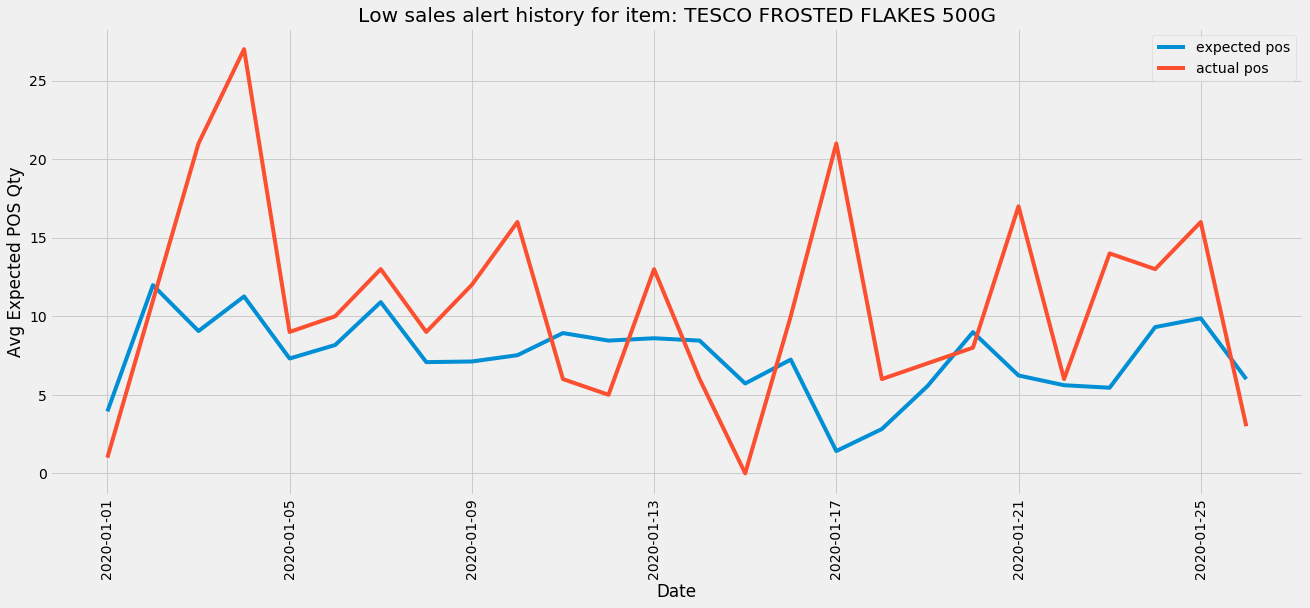

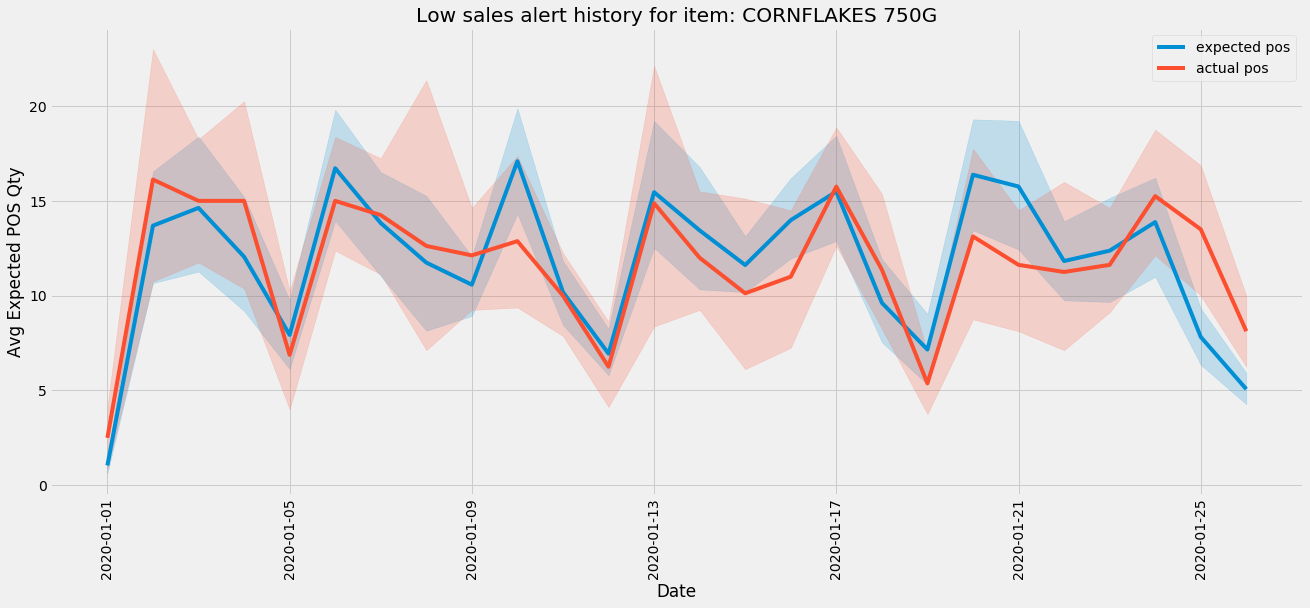

In [17]:
split_date = '2020-01-01'
d2 = df_tesco_alert_history[(df_tesco_alert_history['sales_dt'] >= split_date) & (df_tesco_alert_history['sales_dt'] < '2020-01-27')]

for item in d2['retailer_item_id'].unique():
    
    dd = d2.query(f'retailer_item_id=={item}')
    desc = dd['sku'].unique()[0]
    
    fig, ax = plt.subplots()

    sns.lineplot(x='sales_dt', y='expected_pos', data=dd, ax=ax, label='expected pos')
    sns.lineplot(x='sales_dt', y='pos_item_qty', data=dd, ax=ax, label='actual pos')
    plt.xticks(rotation='vertical')
    plt.ylabel('Avg Expected POS Qty')
    plt.xlabel('Date')
    plt.title(f'Low sales alert history for item: {desc}')
    plt.show()